In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci"   ## <--- set experiment name
seed=42
DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
os.makedirs(EXPERIMENT_DIR,exist_ok=True)

# 2.  Data

- same experiment as in the R CODE 
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df



Setting Seed: 42
         x1        x2        x3
0  0.696075 -0.301980 -2.765247
1  0.236174  0.092973  1.319253
2  0.700131 -0.540465 -5.154250
3  0.402303  0.103458  2.122106
4  0.789859 -0.372750 -2.019175


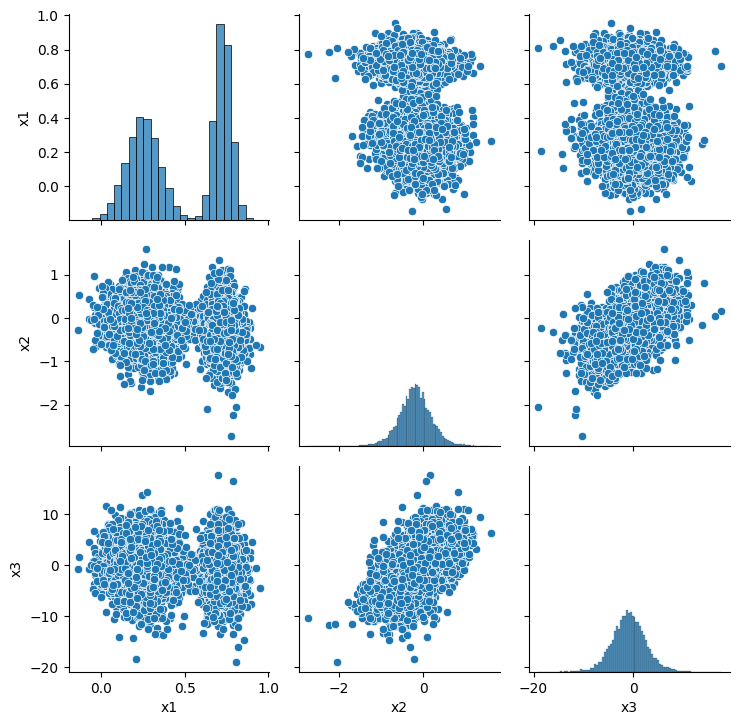

In [3]:

def f(x):
    # Placeholder for the function f(x2) used in x3 generation    
    return 3*x

def dgp(n_obs, doX=(None, None, None), seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")

    # X1: Gaussian mixture
    if doX[0] is None:
        X_1_A = np.random.normal(0.25, 0.1, n_obs)
        X_1_B = np.random.normal(0.73, 0.05, n_obs)
        choice = np.random.choice([0, 1], size=n_obs)
        X_1 = np.where(choice == 0, X_1_A, X_1_B)
    else:
        X_1 = np.full(n_obs, doX[0])

    # X2: transformed from logistic quantile function
    if doX[1] is None:
        U2 = np.random.uniform(size=n_obs)
        x_2_dash = logistic.ppf(U2)
        X_2 = (x_2_dash - 2 * X_1) / 5.0
    else:
        X_2 = np.full(n_obs, doX[1])

    # X3: depends on X1 and X2 through a transformation
    if doX[2] is None:
        U3 = np.random.uniform(size=n_obs)
        x_3_dash = logistic.ppf(U3)
        X_3 = (x_3_dash + 0.2 * X_1 + f(X_2)) / 0.63
    else:
        X_3 = np.full(n_obs, doX[2])
        
    return pd.DataFrame({'x1':X_1,'x2':X_2,'x3':X_3})




# ----- RUN DGP -----
EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")


if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=10_000, doX=(None, None, None), seed=42)

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)

else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")
    


### Standardiz
# # Assuming df is your DataFrame
# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Get min_vals and max_vals as torch tensors
quantiles = df.quantile([0.025, 0.975])
min_vals = quantiles.loc[0.025].values.astype(np.float32)
max_vals = quantiles.loc[0.975].values.astype(np.float32)

sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [4]:
# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


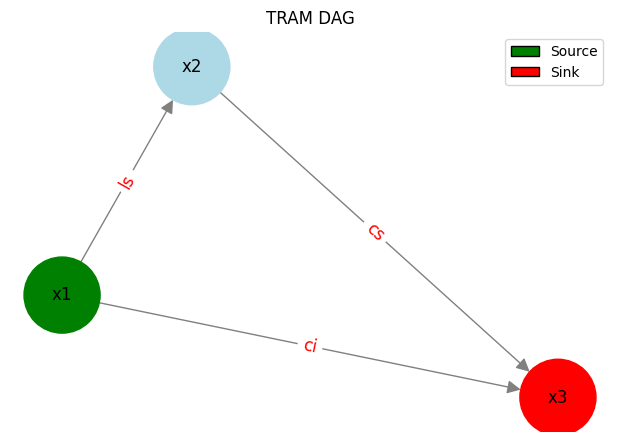

In [5]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# Example 1 dgp tramdag paper  3x3: 
data_type={'x1':'cont','x2':'cont','x3':'cont'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "ls", "ci"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "cs"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)


# its also possible to have ci11 and ci12 etc to inlcude multiple varibales for a network for the intercept. aswell as for cs name it with ci11 ci12

plot_seed=5
plot_dag(adj_matrix,data_type, seed=plot_seed)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


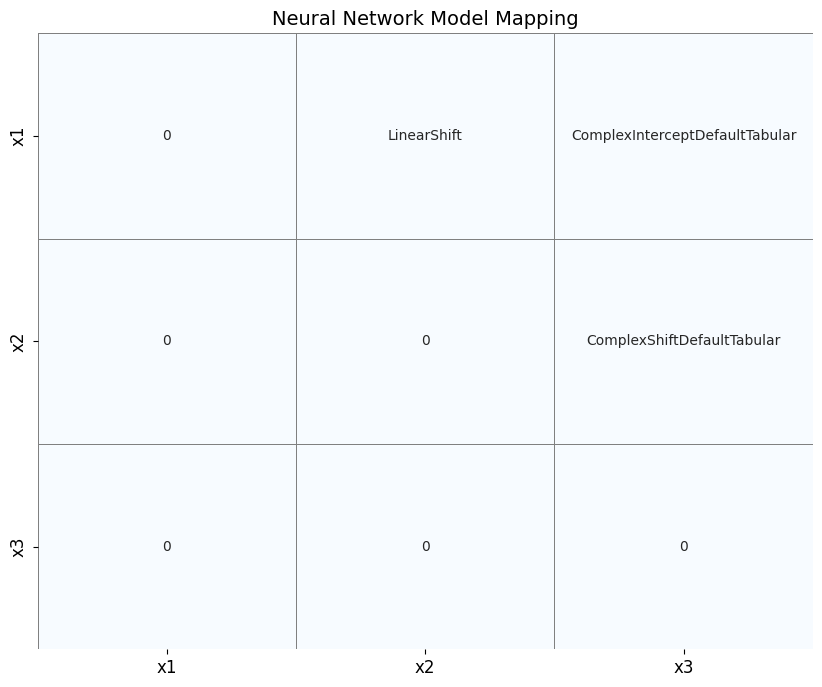

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

- add custom models for the ci or cs

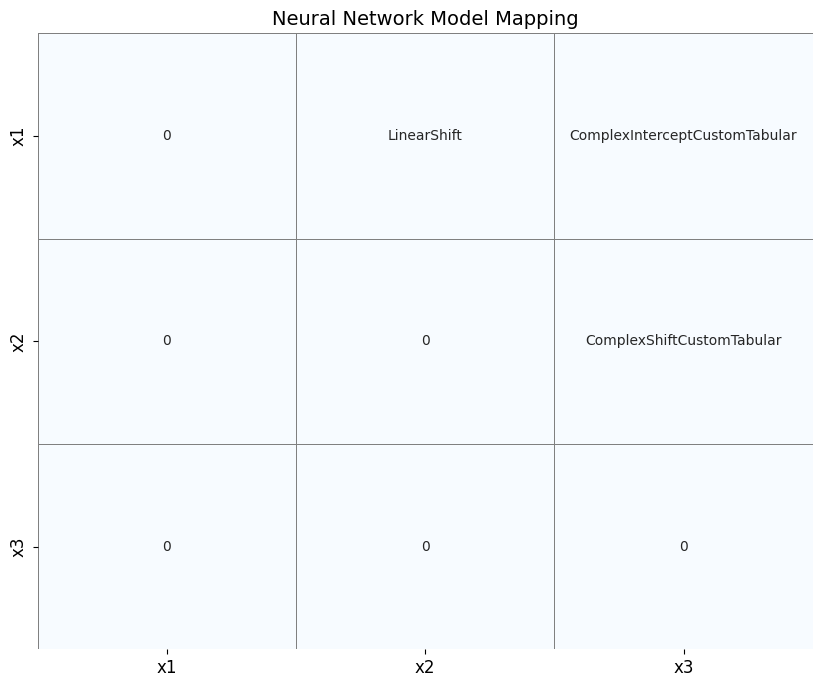

In [7]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# # rename the modelnames in the nn_names_matrix
nn_names_matrix[0,2]='ComplexInterceptCustomTabular'  
nn_names_matrix[1,2]='ComplexShiftCustomTabular'  
plot_nn_names_matrix(nn_names_matrix,data_type)

- model configurations

In [8]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict

Configuration saved to /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci_conf.json


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.08451041579246521,
  'max': 0.8100205063819885},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1'],
  'parents_datatype': {'x1': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ls'},
  'transformation_term_nn_models_in_h()': {'x1': 'LinearShift'},
  'min': -0.9689314961433411,
  'max': 0.5626689195632935},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x1', 'x2'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ci', 'x2': 'cs'},
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexInterceptCustomTabular',
   'x2': 'ComplexShiftCustomTabular'},
  'min': -7.502962589263916,
  'max': 6.060637474060059}}

# 5. Fit models

- each model independently fitting

In [40]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 4112
epochs = 1500   # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = True

In [41]:
# For each NODE 
for node in conf_dict:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)

    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################
    optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.1, eps=1e-8, weight_decay=1e-2)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        train_val_loop(
            start_epoch,
            epochs,
            tram_model,
            train_loader,
            val_loader,
            train_loss_hist,
            val_loss_hist,
            best_val_loss,
            device,
            optimizer,
            use_scheduler,
            scheduler,
            min_max,
            NODE_DIR
        )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 1000...
Saved new best model.
Epoch 1001/1500 | Train Loss: -0.5713 | Val Loss: -0.5712
  [Train: 0.36s | Val: 0.35s | Save: 0.00s | Total: 0.71s]
Saved new best model.
Epoch 1002/1500 | Train Loss: -0.5715 | Val Loss: -0.5714
  [Train: 0.37s | Val: 0.36s | Save: 0.01s | Total: 0.73s]
Saved new best model.
Epoch 1003/1500 | Train Loss: -0.5716 | Val Loss: -0.5715
  [Train: 0.36s | Val: 0.34s | Save: 0.01s | Total: 0.71s]
Saved new best model.
Epoch 1004/1500 | Train Loss: -0.5713 | Val Loss: -0.5716
  [Train: 0.32s | Val: 0.31s | Save: 0.00s | Total: 0.64s]
Saved new best

(out['min'][0],out['max'][1])

# 6 Inspect Training

## 6.1 Loss vs epochs

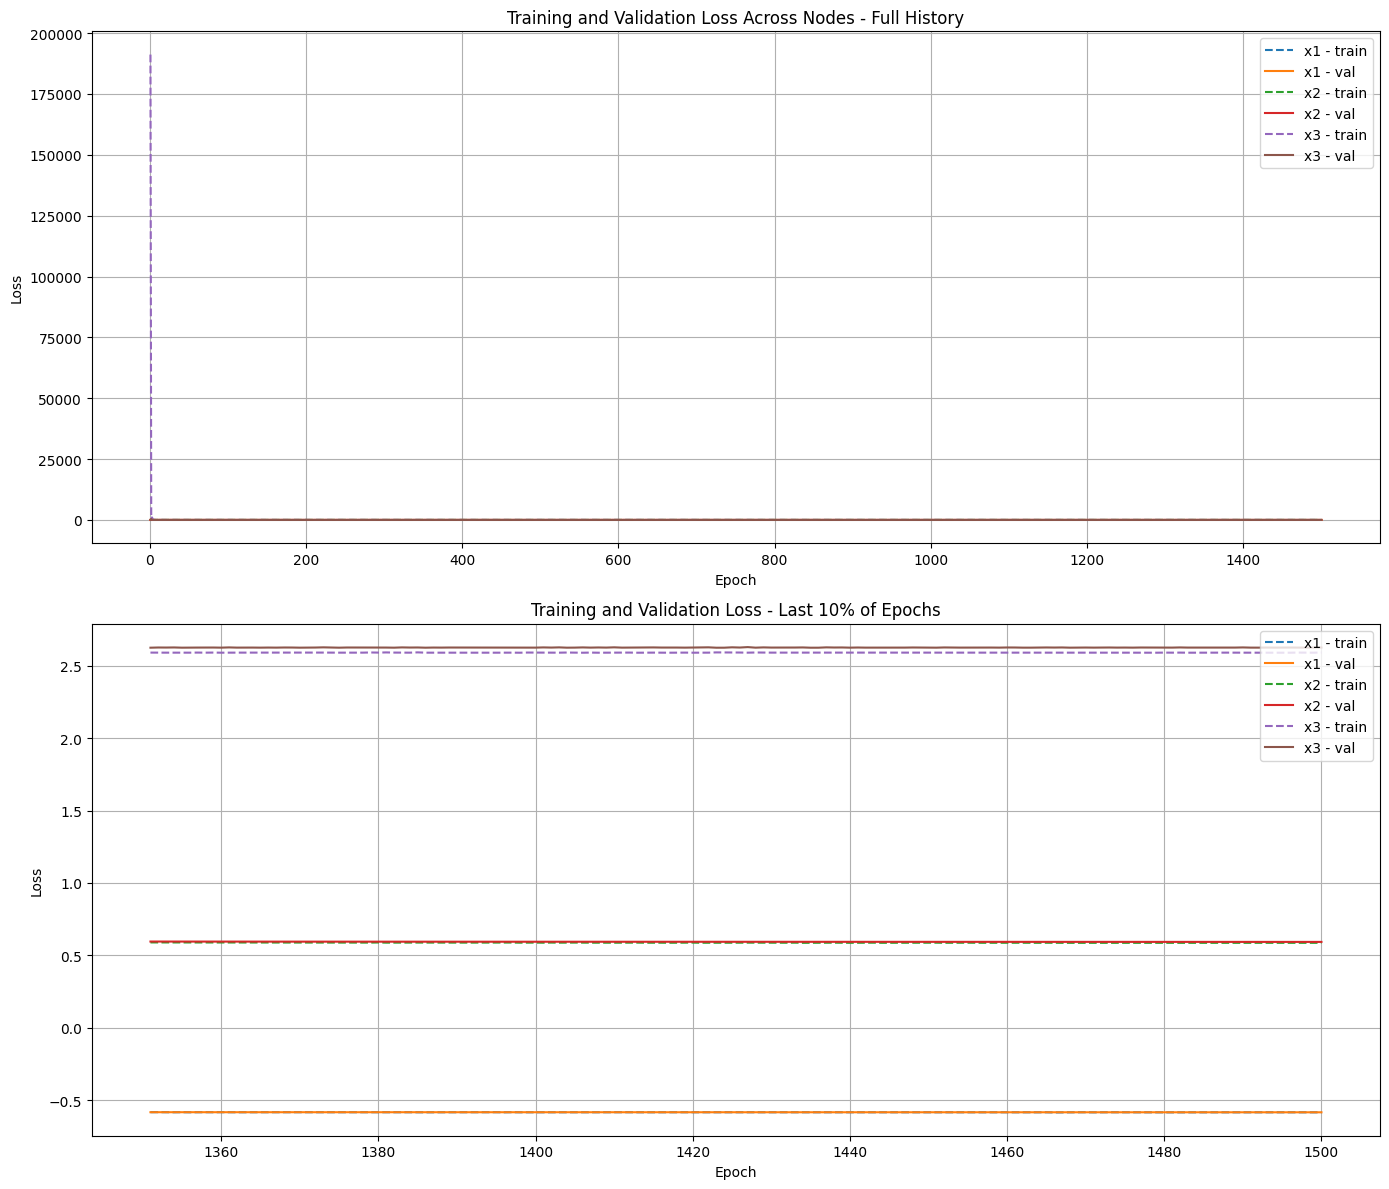

In [42]:
show_training_history(conf_dict,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


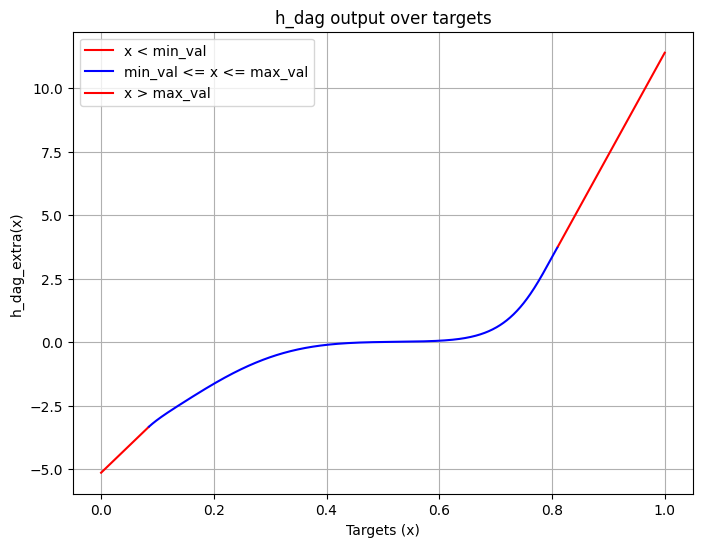


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [43]:
show_hdag_for_source_nodes(conf_dict,EXPERIMENT_DIR,device=device)

## 6.3 Inspect trafo for training data -> should be standard logistic


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--

Processing training data...


Train loader (x1): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]



Processing validation data...


Val loader (x1): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


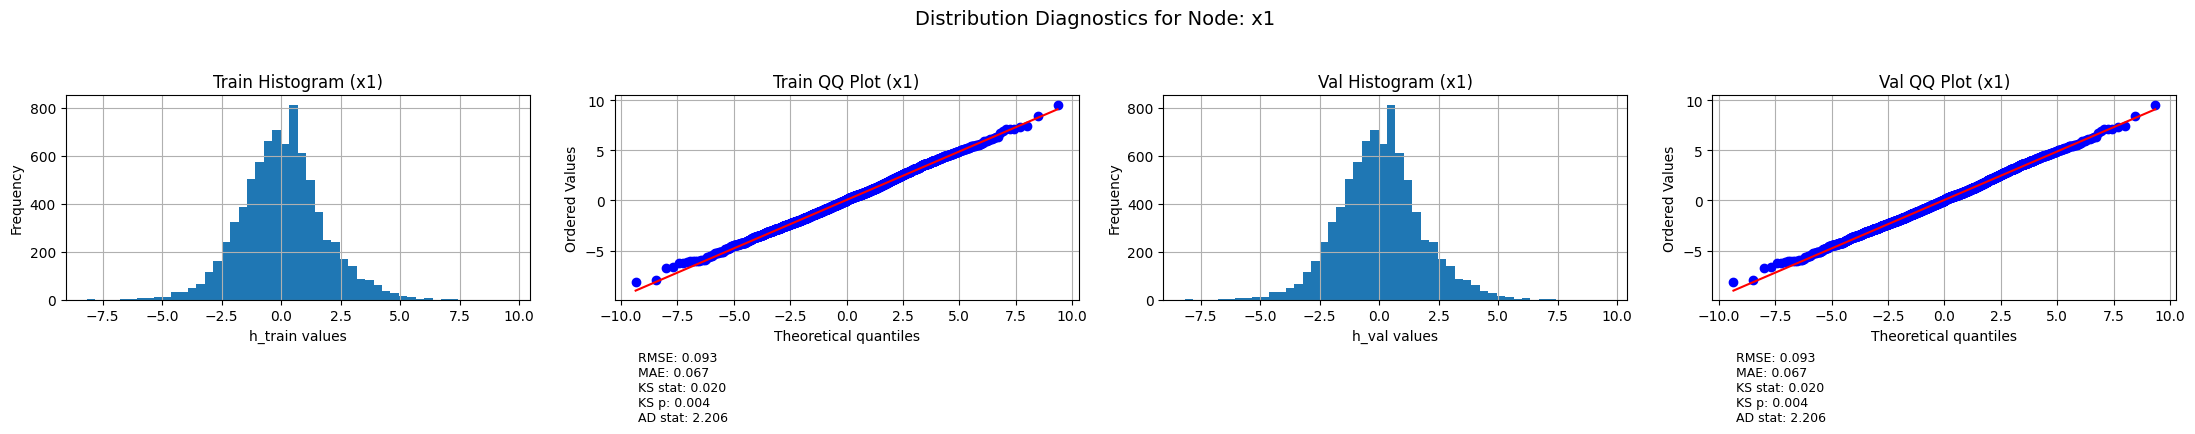


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--

Processing training data...


Train loader (x2): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]



Processing validation data...


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


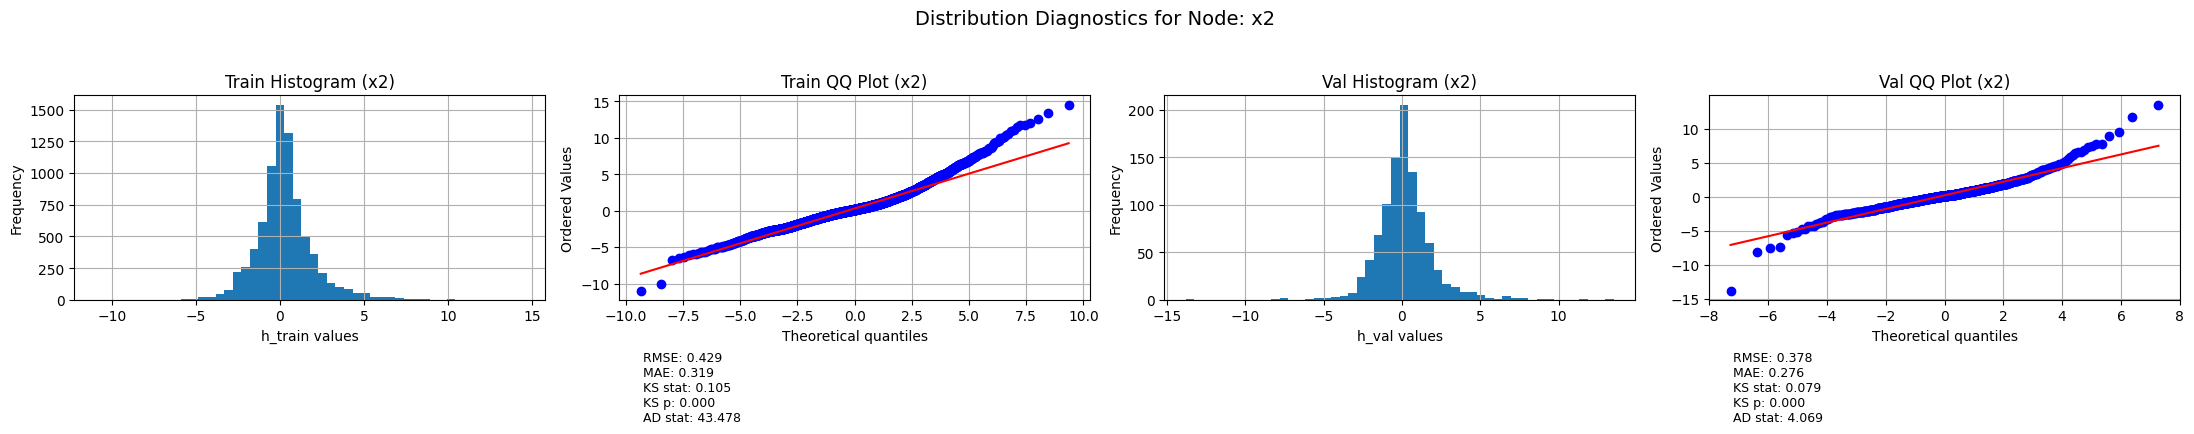


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--

Processing training data...


Train loader (x3): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]



Processing validation data...


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


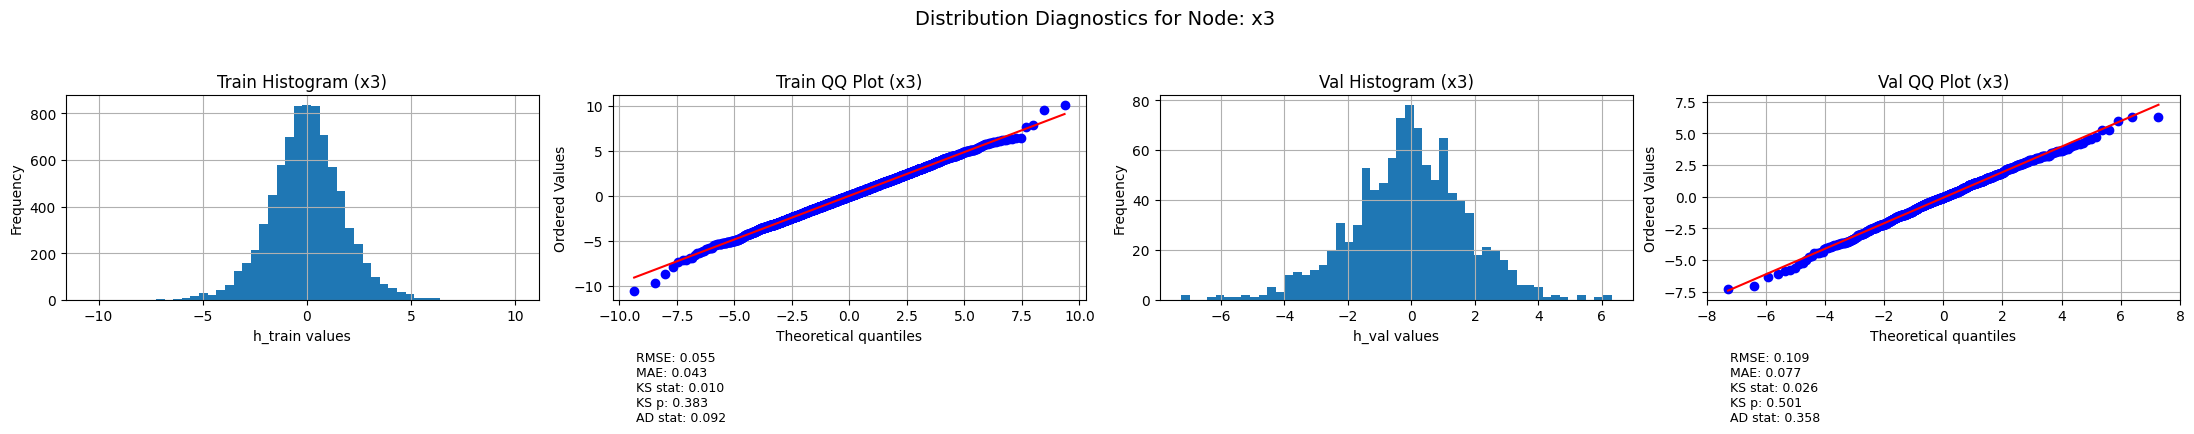

In [44]:
inspect_trafo_standart_logistic(conf_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

In [45]:
conf_dict
EXPERIMENT_DIR
train_df
val_df
device

verbose=False


batch_size = 4112
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    if node != 'x3':
        print('not x3')
        continue
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()

    ##### 2. Dataloader
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=verbose)
    
    #### 3. Forward Pass
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    h_train_list, h_val_list = [], []
    y_pred_list=[]
    with torch.no_grad():
        print("\nProcessing training data...")
        for x, y in tqdm(train_loader, desc=f"Train loader ({node})", total=len(train_loader)):
            y = y.to(device)
            int_input, shift_list = preprocess_inputs(x, device=device)
            
            print(shift_list)
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)
            y_pred_list.append(y_pred)

            
            
            h_train, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
            h_train_list.extend(h_train.cpu().numpy())

        # print("\nProcessing validation data...")
        # for x, y in tqdm(val_loader, desc=f"Val loader ({node})", total=len(val_loader)):
        #     y = y.to(device)
        #     int_input, shift_list = preprocess_inputs(x, device=device)
        #     y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        #     h_val, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        #     h_val_list.extend(h_val.cpu().numpy())

# y_pred_list


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
not x3

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
not x3

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--

Processing training data...


Train loader (x3):   0%|          | 0/2 [00:00<?, ?it/s]

Train loader (x3): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

[tensor([[-0.1090],
        [-0.5810],
        [-0.6677],
        ...,
        [-0.1359],
        [-0.1064],
        [-0.5235]], device='cuda:0')]
[tensor([[-0.7953],
        [ 0.0330],
        [-0.2929],
        ...,
        [-0.1733],
        [-0.0930],
        [-0.2712]], device='cuda:0')]


8000


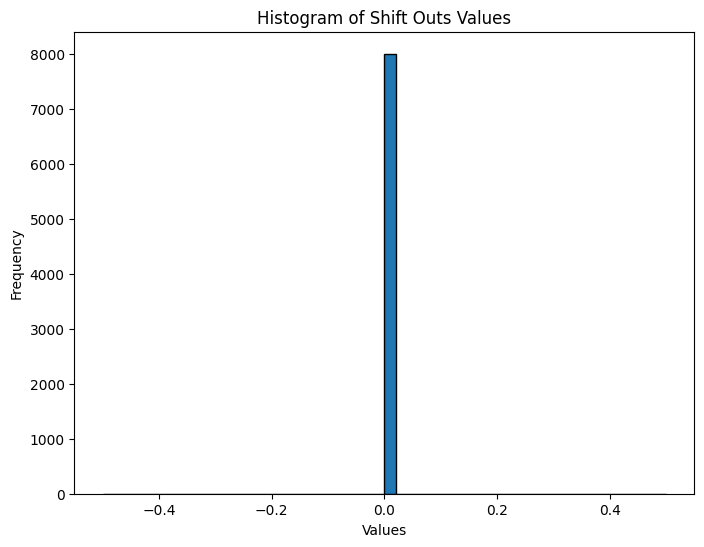

In [46]:
shift_outs = [entry['shift_out'][0].cpu().numpy() for entry in y_pred_list]
shift_outs_combined = np.vstack(shift_outs)

print(len(shift_outs_combined))
plt.figure(figsize=(8, 6))
plt.hist(shift_outs_combined, bins=50, edgecolor='black')
plt.title("Histogram of Shift Outs Values")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

# 7. Sample from Graph

In [47]:
n = 10_000  # Desired number of latent samples 
batch_size = 1
verbose=True
delete_all_previously_sampled=True

## 7.1  Chandrupatla root finder

In [48]:
def sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    

    if delete_all_previously_sampled:
        delete_all_samplings(conf_dict, EXPERIMENT_DIR)
        
    for node in conf_dict:
        print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')
        NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
        SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
        os.makedirs(SAMPLING_DIR, exist_ok=True)
        
        if check_roots_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
            continue
        
        skipping_node = False
        if conf_dict[node]['node_type'] != 'source':
            for parent in conf_dict[node]['parents']:
                if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
                    skipping_node = True
                    break
                
        if skipping_node:
            print(f"Skipping {node} as parent {parent} is not sampled yet.")
            continue
        
        min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
        max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
        min_max = torch.stack([min_vals, max_vals], dim=0)
        
        
        latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
        #latent_sample = truncated_logistic_sample(n=n, low=0, high=1, device=device)
        
        if verbose:
            print("-- sampled latents")
            
        model_path = os.path.join(NODE_DIR, "best_model.pt")
        tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose).to(device)
        tram_model.load_state_dict(torch.load(model_path))
        

            
        if verbose:
            print("-- loaded modelweights")
            
        dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, conf_dict=conf_dict, transform=None)
        sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        
        output_list = []
        with torch.no_grad():
            for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
                x = [xi.to(device) for xi in x]
                int_input, shift_list = preprocess_inputs(x, device=device)
                model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
                output_list.append(model_outputs)
                
        if conf_dict[node]['node_type'] == 'source':
            if verbose:
                print("source node, Defaults to SI and 1 as inputs")
            theta_single = output_list[0]['int_out'][0]
            theta_single = transform_intercepts_continous(theta_single)
            thetas_expanded = theta_single.repeat(n, 1)
            shifts = torch.zeros(n, device=device)
        else:
            if verbose:
                print("node has parents, previously sampled data is loaded for each pa(node)")
            y_pred = merge_outputs(output_list, skip_nan=True)
            shifts = y_pred['shift_out']
            if shifts is None:
                print("shift_out was None; defaulting to zeros.")
                shifts = torch.zeros(n, device=device)
            thetas = y_pred['int_out']
            thetas_expanded = transform_intercepts_continous(thetas).squeeze()
            shifts = shifts.squeeze()
            
        low = torch.full((n,), -1e5, device=device)
        high = torch.full((n,), 1e5, device=device)
        
        ## Root finder using Chandrupatla's method
        def f_vectorized(targets):
            return vectorized_object_function(
                thetas_expanded,
                targets,
                shifts,
                latent_sample,
                k_min=min_max[0],
                k_max=min_max[1]
            )
            
        root = chandrupatla_root_finder(
            f_vectorized,
            low,
            high,
            max_iter=10_000,
            tol=1e-9
        )
        
        ## Saving
        root_path = os.path.join(SAMPLING_DIR, "roots_chandrupatla.pt")
        latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
        
        if torch.isnan(root).any():
            print(f'Caution! Sampling for {node} consists of NaNs')
            
        torch.save(root, root_path)
        torch.save(latent_sample, latents_path)

In [49]:
sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 1,
                            delete_all_previously_sampled=True,
                            verbose=True)        

Deleted directory: /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x1: 100%|██████████| 10000/10000 [00:01<00:00, 5247.16it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 318.41it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/x2/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 10000/10000 [00:01<00:00, 5483.44it/s]


node has parents, previously sampled data is loaded for each pa(node)
shift_out was None; defaulting to zeros.


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 323.83it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_vaca_deeper_cs_ci/x3/sampling
-- sampled latents
>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptCustomTabular(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=32, bias=True)
      (9): ReLU()
      (10): Linear(in_features=32, out_features=16, bias=True)
      (11): ReLU()
      (12): Linear(in_features=16, out_features=20, bias=False)
    )
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftCustomTabular(
      (net): Seque

h() for samples in  x3: 100%|██████████| 10000/10000 [00:10<00:00, 918.46it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:32<00:00, 306.38it/s]


## 7.2 inspect latents
- just sanity check must be standard logistic be design

ValueError: x and y must be the same size

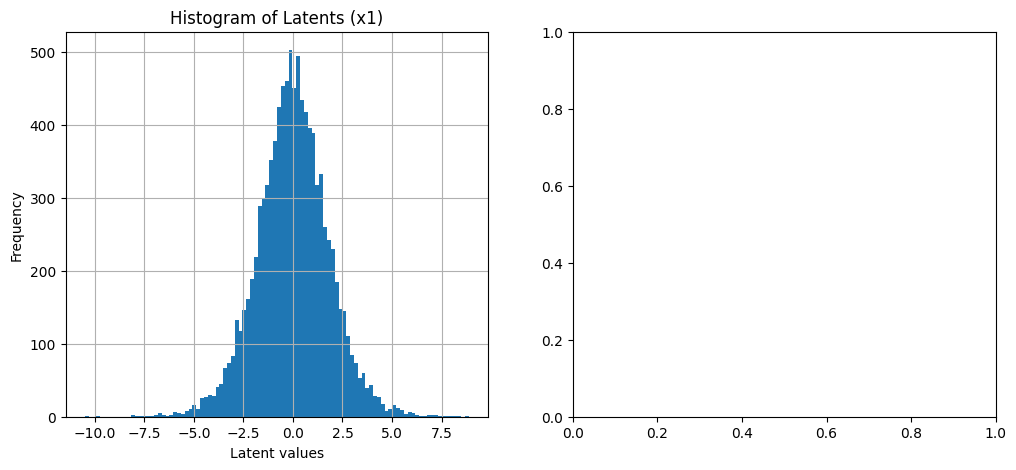

In [51]:
show_latent_sampling(EXPERIMENT_DIR,conf_dict)

## 7.3 Inspect Sampling

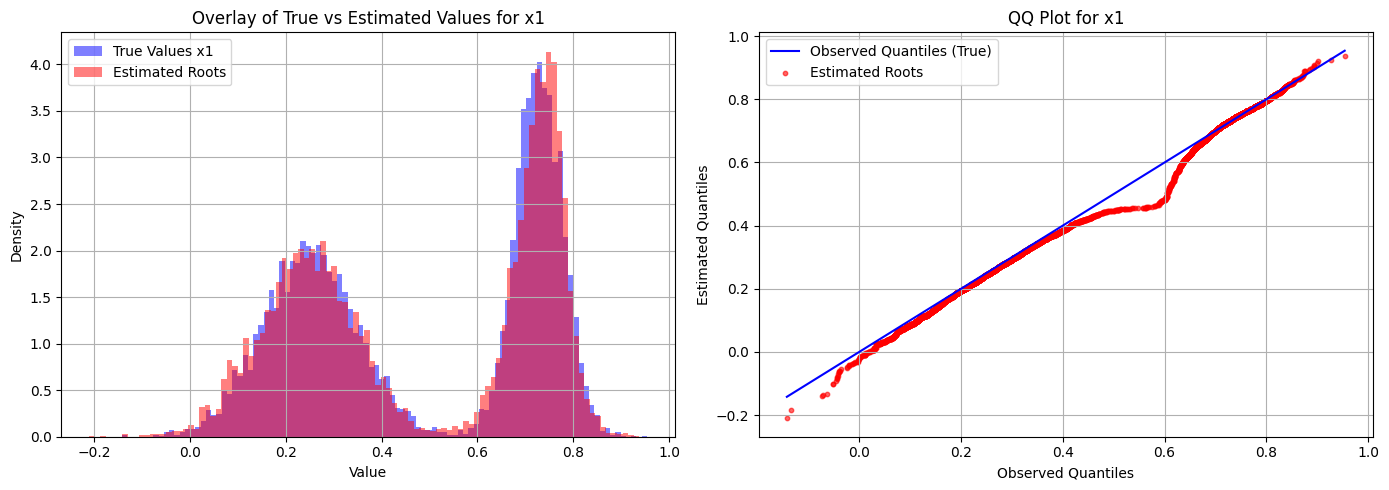

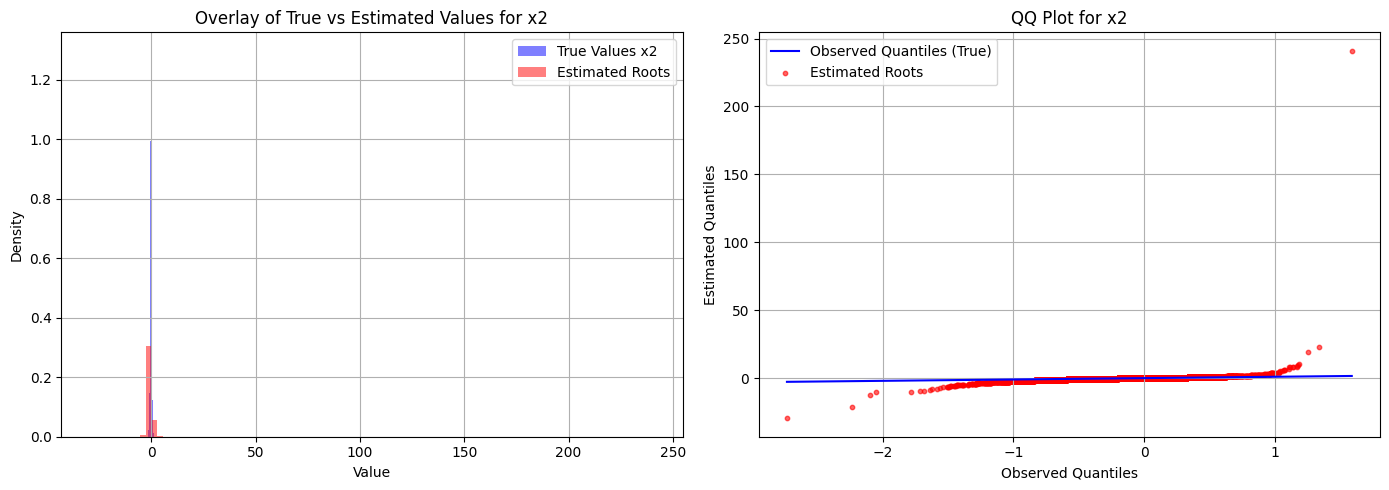

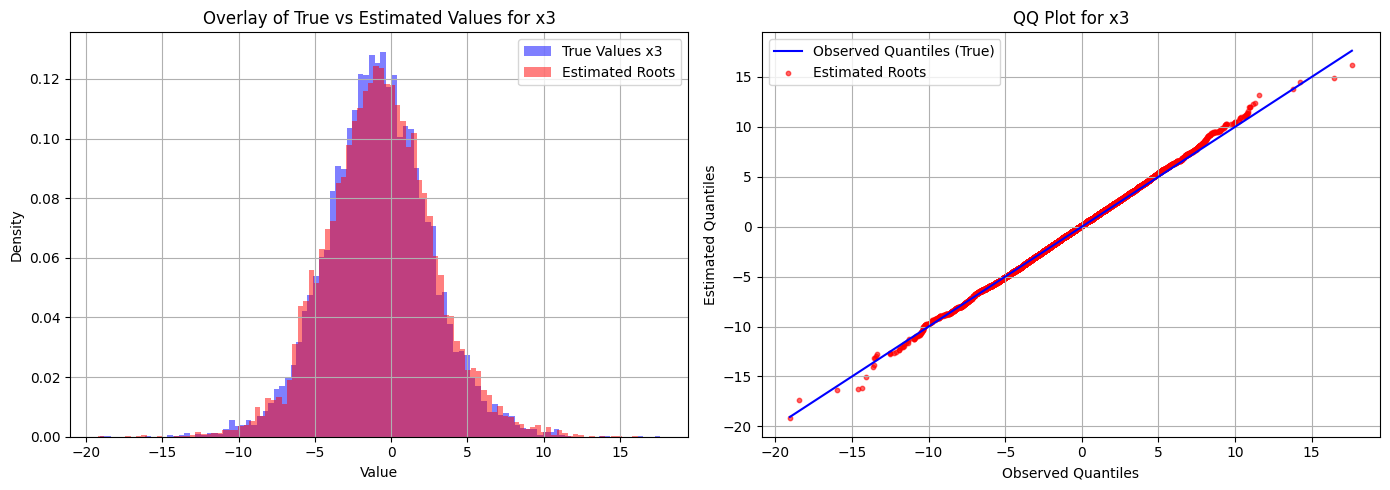

In [52]:
show_samples_vs_true(df,conf_dict,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Do Interventions

## Biscetion

In [21]:
# if delete_all_previously_sampled:
#     delete_all_samplings(conf_dict,EXPERIMENT_DIR)


# for node in conf_dict:
#     print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')
#     NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
#     SAMPLING_DIR=os.path.join(NODE_DIR, 'sampling')
#     os.makedirs(SAMPLING_DIR,exist_ok=True)
    
#     #checkk if parents are sampled already
#     if check_roots_and_latents(NODE_DIR,which='bisection',verbose=verbose):
#         continue
    
#     skipping_node =False
#     # check if node is source or not
#     if conf_dict[node]['node_type'] == 'source':
#         pass
#     else:
#         for parent in conf_dict[node]['parents']:
#             if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent),which='bisection',verbose=verbose):
#                 skipping_node=True
#                 break
            
#     if skipping_node:
#         print(f"Skipping {node} as parent {parent} is not sampled yet.")
#         continue
            
    
#     #sampling from latent
#     # latent_sample = sample_standard_logistic((n,), device=device) # own sampling
#     latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)

#     if verbose:
#         print("-- sampled latents")
    
    
#     # load model 
#     model_path = os.path.join(NODE_DIR, "best_model.pt")
#     tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
#     tram_model = tram_model.to(device)
#     tram_model.load_state_dict(torch.load(model_path))
#     if verbose:
#         print("-- loaded modelweights")
    
#     #Sampling Dataloader
#     dataset = SamplingDataset(node=node,EXPERIMENT_DIR=EXPERIMENT_DIR,number_of_samples=n, conf_dict=conf_dict, transform=None)
#     sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    
#     #Forward pass with the sampled data
#     output_list = []
#     with torch.no_grad():
#         for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
#             x = [xi.to(device) for xi in x]
#             int_input, shift_list = preprocess_inputs(x, device=device)
#             model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
#             output_list.append(model_outputs)

#     if conf_dict[node]['node_type'] == 'source':
        
#         if verbose:
#             print("source node, Defaults to SI and 1 as inputs")
            
#         theta_single =     output_list[0]['int_out'][0]  # Shape: (20,)
#         theta_single=transform_intercepts_continous(theta_single)
#         thetas_expanded = theta_single.repeat(n, 1)  # Shape: (n, 20)
#         shifts = torch.zeros(n, device=device)
        
#     else:
        
#         if verbose:
#             print("node has parents, previously sampled data is loaded for each pa(node)")
            
#         y_pred=merge_outputs(output_list, skip_nan=True)
#         shifts=y_pred['shift_out']
#         if shifts is None:
#             print("shift_out was None; defaulting to zeros.")
#             shifts = torch.zeros(n, device=device)
#         thetas=y_pred['int_out']
#         thetas_expanded=transform_intercepts_continous(thetas).squeeze()
#         shifts=shifts.squeeze()
#         print(thetas_expanded.shape)
#         print(shifts.shape)
        
        

#     low = torch.full((n,), -1e5, device=device)
#     high = torch.full((n,), 1e5, device=device)
#     min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
#     max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
#     min_max = torch.stack([min_vals, max_vals], dim=0)
    

#     ## Root finder
#     root = bisection_root_finder(
#     lambda targets: vectorized_object_function(
#         thetas_expanded,
#         targets,
#         shifts,
#         latent_sample,
#         k_min=min_max[0],
#         k_max=min_max[1]
#     ),low,high, max_iter=10_000,tol=1e-10)
    
#     #### Saving
#     # save root and latents to 
#     root_path = os.path.join(SAMPLING_DIR,"roots_bisection.pt")
#     latents_path=os.path.join(SAMPLING_DIR, "latents.pt")
    
#     if torch.isnan(root).any():
#         print(f'caution! sampling for {node} consits of nans')
    
#     torch.save(root, root_path)
#     torch.save(latent_sample, latents_path)

In [22]:


# for node in conf_dict.keys():
#     root_np = torch.load(f'/home/bule/TramDag/dev_experiment_logs/{experiment_name}/{node}/sampling/roots_bisection.pt').cpu().numpy()
    
#     true_values = train_df[node].dropna().values  # Drop NaNs for fair comparison
    
#     # Sort both arrays for QQ plot
#     sorted_true = np.sort(true_values)
#     sorted_roots = np.sort(root_np)
    
#     min_len = min(len(sorted_true), len(sorted_roots))
#     sorted_true = sorted_true[:min_len]
#     sorted_roots = sorted_roots[:min_len]

#     fig, axs = plt.subplots(1, 2, figsize=(14, 5))

#     # Histogram
#     axs[0].hist(true_values, bins=100, alpha=0.5, label=f'True Values {node}', color='blue', density=True)
#     axs[0].hist(root_np, bins=100, alpha=0.5, label='Estimated Roots', color='red', density=True)
#     axs[0].set_xlabel("Value")
#     axs[0].set_ylabel("Density")
#     axs[0].set_title(f"Overlay of True vs Estimated Values for {node}")
#     axs[0].legend()
#     axs[0].grid(True)

#     # QQ plot
#     axs[1].plot(sorted_true, sorted_true, color='blue', label='Observed Quantiles (True)')
#     axs[1].scatter(sorted_true, sorted_roots, color='red', s=10, alpha=0.6, label='Estimated Roots')
#     axs[1].set_xlabel("Observed Quantiles")
#     axs[1].set_ylabel("Estimated Quantiles")
#     axs[1].set_title(f"QQ Plot for {node}")
#     axs[1].grid(True)
#     axs[1].legend()

#     plt.tight_layout()
#     plt.show()


## Brentq

In [23]:
# delete_all_samplings(conf_dict,EXPERIMENT_DIR)

In [24]:
# from scipy.optimize import brentq

# if delete_all_previously_sampled:
#     delete_all_samplings(conf_dict, EXPERIMENT_DIR)

# for node in conf_dict:
#     print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')
#     NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
#     SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
#     os.makedirs(SAMPLING_DIR, exist_ok=True)

#     if check_roots_and_latents(NODE_DIR,rootfinder='brentq', verbose=verbose):
#         continue

#     skipping_node = False
#     if conf_dict[node]['node_type'] != 'source':
#         for parent in conf_dict[node]['parents']:
#             if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent),rootfinder='brentq', verbose=verbose):
#                 skipping_node = True
#                 break

#     if skipping_node:
#         print(f"Skipping {node} as parent {parent} is not sampled yet.")
#         continue

#     # Sample latents
#     latent_sample = sample_standard_logistic((n,), device=device)
#     if verbose:
#         print("-- sampled latents")

#     # Load model
#     model_path = os.path.join(NODE_DIR, "best_model.pt")
#     tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose).to(device)
#     tram_model.load_state_dict(torch.load(model_path))
#     if verbose:
#         print("-- loaded modelweights")

#     dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, number_of_samples=n,rootfinder='brentq', conf_dict=conf_dict, transform=None)
#     sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

#     output_list = []
#     with torch.no_grad():
#         for x in tqdm(sample_loader, desc=f"Sampling {node}"):
#             x = [xi.to(device) for xi in x]
#             int_input, shift_list = preprocess_inputs(x, device=device)
#             model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
#             output_list.append(model_outputs)

#     if conf_dict[node]['node_type'] == 'source':
#         if verbose:
#             print("source node, Defaults to SI and 1 as inputs")
#         theta_single = output_list[0]['int_out'][0]
#         theta_single = transform_intercepts_continous(theta_single)
#         thetas_expanded = theta_single.repeat(n, 1)
#         shifts = torch.zeros(n, device=device)
#     else:
#         if verbose:
#             print("node has parents, previously sampled data is loaded for each pa(node)")
#         y_pred = merge_outputs(output_list, skip_nan=True)
#         shifts = y_pred['shift_out']
#         if shifts is None:
#             print("shift_out was None; defaulting to zeros.")
#             shifts = torch.zeros(n, device=device)
#         thetas = y_pred['int_out']
#         thetas_expanded = transform_intercepts_continous(thetas).squeeze()
#         shifts = shifts.squeeze()
#         print(thetas_expanded.shape)
#         print(shifts.shape)

#     low = torch.full((n,), -1e5, device=device)
#     high = torch.full((n,), 1e5, device=device)
#     min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
#     max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
#     min_max = torch.stack([min_vals, max_vals], dim=0)

#     ## Root finder using Brent's method
#     roots_list = []
#     for i in range(n):
#         theta_i = thetas_expanded[i:i+1]
#         shift_i = shifts[i:i+1]
#         latent_i = latent_sample[i:i+1]
#         low_i = low[i].item()
#         high_i = high[i].item()
#         k_min_i = min_max[0].item()
#         k_max_i = min_max[1].item()

#         def f_scalar(x):
#             x_tensor = torch.tensor([x], dtype=torch.float32, device=device)
#             return vectorized_object_function(
#                 theta_i,
#                 x_tensor,
#                 shift_i,
#                 latent_i,
#                 k_min=k_min_i,
#                 k_max=k_max_i
#             ).item()

#         try:
#             root_val = brentq(f_scalar, low_i, high_i, xtol=1e-10, rtol=1e-10, maxiter=100)
#         except (ValueError, RuntimeError) as e:
#             print(f"Warning: Root finding failed at index {i}: {e}")
#             root_val = float('nan')

#         roots_list.append(root_val)

#     root = torch.tensor(roots_list, dtype=torch.float32, device=device)

#     ## Saving
#     root_path = os.path.join(SAMPLING_DIR, "roots_brentq.pt")
#     latents_path = os.path.join(SAMPLING_DIR, "latents.pt")

#     if torch.isnan(root).any():
#         print(f'Caution! Sampling for {node} consists of NaNs')

#     torch.save(root, root_path)
#     torch.save(latent_sample, latents_path)


In [25]:

# for node in conf_dict.keys():
#     root_np = torch.load(f'/home/bule/TramDag/dev_experiment_logs/{experiment_name}/{node}/sampling/roots_brentq.pt').cpu().numpy()
    
#     true_values = df[node].dropna().values  # Drop NaNs for fair comparison
    
#     # Sort both arrays for QQ plot
#     sorted_true = np.sort(true_values)
#     sorted_roots = np.sort(root_np)
    
#     min_len = min(len(sorted_true), len(sorted_roots))
#     sorted_true = sorted_true[:min_len]
#     sorted_roots = sorted_roots[:min_len]

#     fig, axs = plt.subplots(1, 2, figsize=(14, 5))

#     # Histogram
#     axs[0].hist(true_values, bins=100, alpha=0.5, label=f'True Values {node}', color='blue', density=True)
#     axs[0].hist(root_np, bins=100, alpha=0.5, label='Estimated Roots', color='red', density=True)
#     axs[0].set_xlabel("Value")
#     axs[0].set_ylabel("Density")
#     axs[0].set_title(f"Overlay of True vs Estimated Values for {node}")
#     axs[0].legend()
#     axs[0].grid(True)

#     # QQ plot
#     axs[1].plot(sorted_true, sorted_true, color='blue', label='Observed Quantiles (True)')
#     axs[1].scatter(sorted_true, sorted_roots, color='red', s=10, alpha=0.6, label='Estimated Roots')
#     axs[1].set_xlabel("Observed Quantiles")
#     axs[1].set_ylabel("Estimated Quantiles")
#     axs[1].set_title(f"QQ Plot for {node}")
#     axs[1].grid(True)
#     axs[1].legend()

#     plt.tight_layout()
#     plt.show()
